# STEP 1: Import Libraries 

Step awal ini berfungsi menyiapkan seluruh alat yang diperlukan sebelum proses analisis dan pemodelan dilakukan. Pada tahap ini, digunakan library seperti pandas dan numpy untuk keperluan manipulasi serta pengolahan data. Untuk pemodelan machine learning, disertakan xgboost, sebuah algoritma gradient boosting yang sangat kuat dan populer untuk data tabular, serta berbagai modul dari scikit-learn. Karena dataset penipuan umumnya tidak seimbang, digunakan pula library imblearn untuk menangani class imbalance melalui teknik seperti SMOTE dan RandomUnderSampler, sehingga model dapat belajar secara lebih adil antara kelas normal dan penipuan. Selain itu, disiapkan metrik evaluasi yang lebih informatif dibanding sekadar akurasi, yaitu roc_auc_score dan precision_recall_curve, yang lebih tepat untuk menilai performa model pada kasus dengan distribusi kelas yang timpang.

In [9]:
import numpy as np
import pandas as pd
import gdown
import gc
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.metrics import roc_auc_score, precision_recall_curve, average_precision_score
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as ImbPipeline

import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt

print("✅ Libraries imported!")

✅ Libraries imported!


# STEP 2: Memory Optimization

Dataset penipuan, seperti IEEE-CIS, biasanya sangat besar sehingga berisiko memenuhi kapasitas RAM dan menyebabkan crash. Untuk mengatasi hal ini, dilakukan langkah optimisasi tipe data menggunakan fungsi optimize_dtypes. Fungsi ini memindai setiap kolom dalam DataFrame dan menyesuaikan tipe data berdasarkan nilai yang terkandung. Misalnya, kolom yang berisi angka kecil (seperti 1–100) tidak perlu disimpan sebagai int64 yang memakan banyak memori, sehingga dapat dikonversi menjadi int8 atau int16; hal serupa diterapkan pada tipe float. Dengan pendekatan ini, penggunaan memori dapat dikurangi secara signifikan, seringkali lebih dari 50%, tanpa mengorbankan informasi penting dalam dataset.

In [10]:
def optimize_dtypes(df, verbose=True):
    """Optimize datatypes using dictionary mapping"""
    start_mem = df.memory_usage().sum() / 1024**2

    # Define optimal types
    int_types = [np.int8, np.int16, np.int32, np.int64]
    float_types = [np.float16, np.float32, np.float64]

    for col in df.columns:
        col_type = df[col].dtype

        if col_type in ['int64', 'int32']:
            c_min, c_max = df[col].min(), df[col].max()
            for int_type in int_types:
                if c_min > np.iinfo(int_type).min and c_max < np.iinfo(int_type).max:
                    df[col] = df[col].astype(int_type)
                    break

        elif col_type in ['float64', 'float32']:
            c_min, c_max = df[col].min(), df[col].max()
            for float_type in float_types:
                if c_min > np.finfo(float_type).min and c_max < np.finfo(float_type).max:
                    df[col] = df[col].astype(float_type)
                    break

    end_mem = df.memory_usage().sum() / 1024**2
    if verbose:
        reduction = 100 * (start_mem - end_mem) / start_mem
        print(f'Memory optimized: {start_mem:.1f}MB → {end_mem:.1f}MB ({reduction:.1f}% ↓)')

    return df

# Data Load

In [11]:
# Download files
train_url = 'https://drive.google.com/uc?id=1vA9rGGPElhn7rARS1qJyIAUJDny36mhy'
test_url = 'https://drive.google.com/uc?id=182S6yNqDfluSw6FIvya5ZGD-3ia963Lx'

gdown.download(train_url, 'train_transaction.csv', quiet=False)
gdown.download(test_url, 'test_transaction.csv', quiet=False)

# Define columns to use (drop high-missing and less useful columns)
use_cols_train = ['TransactionID', 'isFraud', 'TransactionDT', 'TransactionAmt',
                  'ProductCD', 'card1', 'card2', 'card3', 'card4', 'card5', 'card6',
                  'addr1', 'addr2', 'dist1', 'P_emaildomain', 'R_emaildomain',
                  'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13', 'C14',
                  'D1', 'D2', 'D3', 'D4', 'D5', 'D10', 'D11', 'D15',
                  'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
                  'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
                  'V29', 'V30', 'V31', 'V32', 'V33', 'V34', 'V35', 'V36', 'V37', 'V38',
                  'V44', 'V45', 'V46', 'V47', 'V48', 'V49', 'V50', 'V51', 'V52', 'V53', 'V54',
                  'V69', 'V70', 'V71', 'V72', 'V73', 'V74', 'V75', 'V76', 'V77', 'V78',
                  'V279', 'V280', 'V281', 'V282', 'V283', 'V284', 'V285', 'V286', 'V287',
                  'V294', 'V295', 'V296', 'V297', 'V298', 'V299', 'V300', 'V301', 'V302', 'V303', 'V304',
                  'V306', 'V307', 'V308', 'V309', 'V310', 'V311', 'V312', 'V313', 'V314', 'V315', 'V316', 'V317', 'V318', 'V319', 'V320', 'V321']

use_cols_test = [c for c in use_cols_train if c != 'isFraud']

# Load only selected columns
print("\n📂 Loading train data...")
train = pd.read_csv('train_transaction.csv', usecols=use_cols_train)
train = optimize_dtypes(train)  # ✅ GANTI DENGAN FUNGSI BARU
gc.collect()

print("\n📂 Loading test data...")
test = pd.read_csv('test_transaction.csv', usecols=use_cols_test)
test = optimize_dtypes(test)  # ✅ GANTI DENGAN FUNGSI BARU
gc.collect()

print(f"\n✅ Train shape: {train.shape}")
print(f"✅ Test shape: {test.shape}")
print(f"✅ Fraud rate: {train['isFraud'].mean()*100:.2f}%")

# Store test IDs
test_ids = test['TransactionID'].values.copy()

Downloading...
From (original): https://drive.google.com/uc?id=1vA9rGGPElhn7rARS1qJyIAUJDny36mhy
From (redirected): https://drive.google.com/uc?id=1vA9rGGPElhn7rARS1qJyIAUJDny36mhy&confirm=t&uuid=3efb9f89-dbf5-41e5-89d7-29429f307d36
To: /content/train_transaction.csv
100%|██████████| 683M/683M [00:06<00:00, 98.4MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=182S6yNqDfluSw6FIvya5ZGD-3ia963Lx
From (redirected): https://drive.google.com/uc?id=182S6yNqDfluSw6FIvya5ZGD-3ia963Lx&confirm=t&uuid=0270eb1e-868d-46a3-9b8d-2b9a5d14c6fb
To: /content/test_transaction.csv
100%|██████████| 613M/613M [00:07<00:00, 76.7MB/s]



📂 Loading train data...
Memory optimized: 563.2MB → 169.5MB (69.9% ↓)

📂 Loading test data...
Memory optimized: 479.4MB → 146.9MB (69.4% ↓)

✅ Train shape: (590540, 125)
✅ Test shape: (506691, 124)
✅ Fraud rate: 3.50%


# STEP 3: EDA

Analisis awal pada dataset penipuan mencakup beberapa aspek penting untuk memahami karakteristik target dan data transaksi. Pertama, dilakukan Analisis Target dengan membandingkan jumlah transaksi Fraud versus Non-Fraud, di mana rasio kelas biasanya sangat timpang, misalnya hanya sekitar 3,5% transaksi yang merupakan penipuan. Selanjutnya, Statistik Transaksi diperiksa melalui distribusi nilai transaksi (TransactionAmt) untuk melihat apakah transaksi penipuan cenderung bernilai besar atau kecil. Tahap berikutnya adalah identifikasi Missing Values, yaitu menentukan kolom mana saja yang memiliki banyak nilai kosong. Untuk memudahkan interpretasi, dilakukan beberapa visualisasi: Pie Chart untuk menampilkan proporsi transaksi Fraud vs Non-Fraud, Box Plot untuk melihat sebaran nilai transaksi yang biasanya menunjukkan banyak outlier pada data penipuan, serta analisis Fraud by Product untuk mengetahui produk atau kategori mana yang paling rentan terhadap penipuan.


📊 EXPLORATORY DATA ANALYSIS

🎯 Target Distribution:
   Non-Fraud: 569,877 (96.50%)
   Fraud: 20,663 (3.50%)

💰 Transaction Amount Statistics:
            count  mean     std       min       25%   50%    75%      max
isFraud                                                                  
0        569877.0   NaN    0.00  0.250977  43.96875  68.5  120.0  31936.0
1         20663.0   inf  232.25  0.291992  35.03125  75.0  161.0   5192.0

🔍 Missing Values Analysis:
   Columns with >30% missing: 17
R_emaildomain    76.751617
dist1            59.652352
D5               52.467403
D2               47.549192
V9               47.293494
V1               47.293494
V2               47.293494
V3               47.293494
V4               47.293494
V6               47.293494
dtype: float64


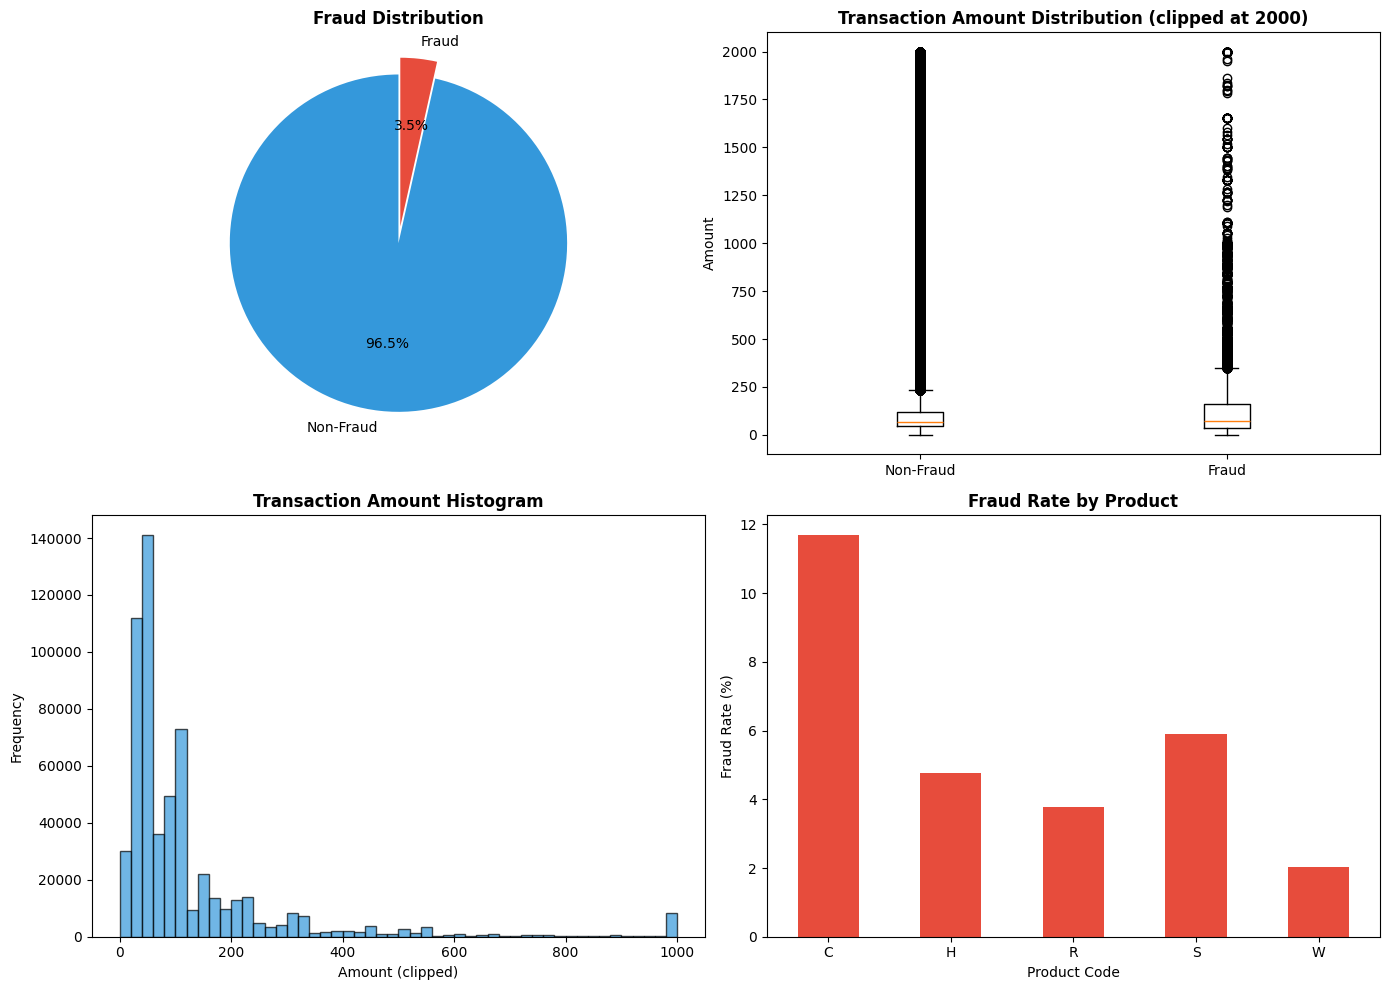


✅ EDA completed! Saved as 'eda_analysis.png'


In [7]:
print("\n📊 EXPLORATORY DATA ANALYSIS")
print("="*60)

# 1. Target distribution
fraud_counts = train['isFraud'].value_counts()
fraud_rate = train['isFraud'].mean() * 100
print(f"\n🎯 Target Distribution:")
print(f"   Non-Fraud: {fraud_counts[0]:,} ({100-fraud_rate:.2f}%)")
print(f"   Fraud: {fraud_counts[1]:,} ({fraud_rate:.2f}%)")

# 2. Transaction Amount statistics
print(f"\n💰 Transaction Amount Statistics:")
print(train.groupby('isFraud')['TransactionAmt'].describe())

# 3. Missing values analysis
print(f"\n🔍 Missing Values Analysis:")
missing_pct = (train.isnull().sum() / len(train) * 100).sort_values(ascending=False)
high_missing = missing_pct[missing_pct > 30]
print(f"   Columns with >30% missing: {len(high_missing)}")
print(high_missing.head(10))

# 4. Visualizations
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Fraud distribution (pie chart)
axes[0, 0].pie(fraud_counts, labels=['Non-Fraud', 'Fraud'],
               autopct='%1.1f%%', colors=['#3498db', '#e74c3c'],
               startangle=90, explode=(0, 0.1))
axes[0, 0].set_title('Fraud Distribution', fontsize=12, weight='bold')

# Transaction Amount by Fraud (box plot)
fraud_amt = train[train['isFraud']==1]['TransactionAmt'].clip(upper=2000)
non_fraud_amt = train[train['isFraud']==0]['TransactionAmt'].clip(upper=2000)
axes[0, 1].boxplot([non_fraud_amt, fraud_amt], labels=['Non-Fraud', 'Fraud'])
axes[0, 1].set_title('Transaction Amount Distribution (clipped at 2000)',
                      fontsize=12, weight='bold')
axes[0, 1].set_ylabel('Amount')

# Transaction Amount histogram
axes[1, 0].hist(train['TransactionAmt'].clip(upper=1000), bins=50,
                color='#3498db', alpha=0.7, edgecolor='black')
axes[1, 0].set_title('Transaction Amount Histogram', fontsize=12, weight='bold')
axes[1, 0].set_xlabel('Amount (clipped)')
axes[1, 0].set_ylabel('Frequency')

# Product distribution by fraud
product_fraud = train.groupby(['ProductCD', 'isFraud']).size().unstack(fill_value=0)
product_fraud_rate = product_fraud[1] / product_fraud.sum(axis=1) * 100
product_fraud_rate.plot(kind='bar', ax=axes[1, 1], color='#e74c3c')
axes[1, 1].set_title('Fraud Rate by Product', fontsize=12, weight='bold')
axes[1, 1].set_xlabel('Product Code')
axes[1, 1].set_ylabel('Fraud Rate (%)')
axes[1, 1].tick_params(axis='x', rotation=0)

plt.tight_layout()
plt.savefig('eda_analysis.png', dpi=100, bbox_inches='tight')
plt.show()

print("\n✅ EDA completed! Saved as 'eda_analysis.png'")

# STEP 4: Feature Engineering

Step ini merupakan tahapan untuk meningkatkan akurasi model, karena model membutuhkan konteks lebih dari sekadar data mentah. Pada Time Features, kolom TransactionDT diubah menjadi informasi jam dan hari, karena penipuan sering terjadi pada jam-jam tidak wajar, seperti tengah malam. Pada transformasi Amount, dilakukan analisis bagian desimal transaksi karena penipu cenderung menggunakan angka unik di belakang koma, serta penerapan log transform untuk menormalkan distribusi jumlah transaksi yang miring (skewed). Selanjutnya, Aggregations (Groupby) digunakan sebagai teknik deteksi anomali; misalnya, fitur card1_TransactionAmt_mean memungkinkan model belajar apakah transaksi tertentu jauh lebih besar daripada rata-rata transaksi kartu tersebut sebelumnya, sedangkan fitur _count menunjukkan frekuensi kemunculan kartu atau alamat, sehingga pola abnormal seperti 100 transaksi dalam satu jam dapat terdeteksi sebagai potensi serangan bot. Selain itu, fitur Interaction dibuat dengan menggabungkan card1 dan addr1 untuk menghasilkan identitas unik pengguna, memperkaya informasi yang dapat dimanfaatkan model dalam mendeteksi penipuan.

In [16]:
def engineer_features(df):
    """Advanced feature engineering with aggregations and interactions"""

    print("\n🔧 Engineering features...")

    # 1. Time-based features
    df['TransactionDT_hour'] = ((df['TransactionDT'] / 3600) % 24).astype(np.int8)
    df['TransactionDT_day'] = ((df['TransactionDT'] / (3600 * 24)) % 7).astype(np.int8)
    df['TransactionDT_week'] = (df['TransactionDT'] / (3600 * 24 * 7)).astype(np.int16)

    # 2. Amount transformations (keep as float32 to avoid groupby issues)
    df['TransactionAmt'] = df['TransactionAmt'].astype(np.float32)
    df['TransactionAmt_log'] = np.log1p(df['TransactionAmt']).astype(np.float32)
    df['TransactionAmt_sqrt'] = np.sqrt(df['TransactionAmt']).astype(np.float32)
    df['TransactionAmt_decimal'] = (df['TransactionAmt'] - df['TransactionAmt'].astype(int)).astype(np.float32)
    df['TransactionAmt_rounded'] = df['TransactionAmt'].round().astype(np.int32)

    # 3. Card aggregations (convert to float32 before groupby)
    for col in ['card1', 'card2', 'card3']:
        if col in df.columns:
            # Ensure column is not float16
            if df[col].dtype == np.float16:
                df[col] = df[col].astype(np.float32)

            # Fill NaN temporarily for aggregation
            temp_filled = df[col].fillna(-999)

            df[f'{col}_TransactionAmt_mean'] = df.groupby(temp_filled)['TransactionAmt'].transform('mean').astype(np.float32)
            df[f'{col}_TransactionAmt_std'] = df.groupby(temp_filled)['TransactionAmt'].transform('std').fillna(0).astype(np.float32)
            df[f'{col}_count'] = df.groupby(temp_filled)[col].transform('count').fillna(0).astype(np.float32)

    # 4. Address aggregations
    if 'addr1' in df.columns:
        if df['addr1'].dtype == np.float16:
            df['addr1'] = df['addr1'].astype(np.float32)

        temp_addr1 = df['addr1'].fillna(-999)
        df['addr1_count'] = df.groupby(temp_addr1)['addr1'].transform('count').fillna(0).astype(np.float32)
        df['addr1_TransactionAmt_mean'] = df.groupby(temp_addr1)['TransactionAmt'].transform('mean').astype(np.float32)

    if 'addr2' in df.columns:
        if df['addr2'].dtype == np.float16:
            df['addr2'] = df['addr2'].astype(np.float32)

        temp_addr2 = df['addr2'].fillna(-999)
        df['addr2_count'] = df.groupby(temp_addr2)['addr2'].transform('count').fillna(0).astype(np.float32)

    # 5. Email domain features (handle object types)
    if 'P_emaildomain' in df.columns and df['P_emaildomain'].dtype == 'object':
        temp_pemail = df['P_emaildomain'].fillna('unknown')
        df['P_emaildomain_count'] = df.groupby(temp_pemail)['P_emaildomain'].transform('count').astype(np.float32)

    if 'R_emaildomain' in df.columns and df['R_emaildomain'].dtype == 'object':
        temp_remail = df['R_emaildomain'].fillna('unknown')
        df['R_emaildomain_count'] = df.groupby(temp_remail)['R_emaildomain'].transform('count').astype(np.float32)

    # 6. Interaction features
    if 'card1' in df.columns and 'addr1' in df.columns:
        card1_str = df['card1'].fillna(-999).astype(str)
        addr1_str = df['addr1'].fillna(-999).astype(str)
        df['card1_addr1'] = (card1_str + '_' + addr1_str).astype('category').cat.codes.astype(np.int32)

    # 7. C columns aggregations (convert float16 to float32)
    c_cols = [c for c in df.columns if c.startswith('C')]
    if len(c_cols) > 0:
        for col in c_cols:
            if df[col].dtype == np.float16:
                df[col] = df[col].astype(np.float32)

        df['C_sum'] = df[c_cols].sum(axis=1).astype(np.float32)
        df['C_mean'] = df[c_cols].mean(axis=1).astype(np.float32)
        df['C_std'] = df[c_cols].std(axis=1).fillna(0).astype(np.float32)
        df['C_max'] = df[c_cols].max(axis=1).astype(np.float32)
        df['C_min'] = df[c_cols].min(axis=1).astype(np.float32)

    # 8. D columns aggregations (convert float16 to float32)
    d_cols = [c for c in df.columns if c.startswith('D')]
    if len(d_cols) > 0:
        for col in d_cols:
            if df[col].dtype == np.float16:
                df[col] = df[col].astype(np.float32)

        df['D_sum'] = df[d_cols].sum(axis=1).astype(np.float32)
        df['D_nulls'] = df[d_cols].isnull().sum(axis=1).astype(np.int8)
        df['D_mean'] = df[d_cols].mean(axis=1).astype(np.float32)

    # 9. V columns aggregations (convert float16 to float32)
    v_cols = [c for c in df.columns if c.startswith('V')]
    if len(v_cols) > 0:
        for col in v_cols:
            if df[col].dtype == np.float16:
                df[col] = df[col].astype(np.float32)

        df['V_sum'] = df[v_cols].sum(axis=1).astype(np.float32)
        df['V_mean'] = df[v_cols].mean(axis=1).astype(np.float32)
        df['V_std'] = df[v_cols].std(axis=1).fillna(0).astype(np.float32)
        df['V_nulls'] = df[v_cols].isnull().sum(axis=1).astype(np.int8)

    # 10. ProductCD features (if object type)
    if 'ProductCD' in df.columns and df['ProductCD'].dtype == 'object':
        temp_product = df['ProductCD'].fillna('unknown')
        df['ProductCD_TransactionAmt_mean'] = df.groupby(temp_product)['TransactionAmt'].transform('mean').astype(np.float32)
        df['ProductCD_count'] = df.groupby(temp_product)['ProductCD'].transform('count').astype(np.float32)

    # Drop original TransactionDT
    df.drop('TransactionDT', axis=1, inplace=True)

    # Get number of new features
    initial_cols = len(use_cols_train) - 1  # minus TransactionDT
    new_features = df.shape[1] - initial_cols
    print(f"   ✓ Created {new_features} new features")

    return df

# Apply feature engineering
train = engineer_features(train)
test = engineer_features(test)
gc.collect()

print(f"\n✅ Features engineered!")
print(f"   Train shape: {train.shape}")
print(f"   Test shape: {test.shape}")


🔧 Engineering features...
   ✓ Created 36 new features

🔧 Engineering features...
   ✓ Created 35 new features

✅ Features engineered!
   Train shape: (590540, 160)
   Test shape: (506691, 159)


# STEP 5: Data Preprocessing

Langkah ini menyiapkan data agar dapat diproses dengan optimal oleh algoritma XGBoost. Pertama, dilakukan Frequency Encoding pada data kategori, misalnya nama bank seperti “Visa” atau “Mastercard”, dengan mengganti kategori menjadi angka berdasarkan frekuensi kemunculannya. Pendekatan ini seringkali lebih efektif daripada One-Hot Encoding untuk model berbasis tree. Selanjutnya, dilakukan Imputation untuk mengisi nilai yang hilang (NaN) menggunakan nilai median, sehingga statistik data tetap terjaga. Terakhir, Robust Scaling diterapkan pada fitur numerik menggunakan RobustScaler, yang menstandarisasi data sekaligus tahan terhadap outlier ekstrem—fenomena yang umum ditemukan dalam dataset keuangan.

In [17]:
print("\n🔄 PREPROCESSING DATA")
print("="*60)

# Separate target
y = train['isFraud'].values
train.drop(['isFraud', 'TransactionID'], axis=1, inplace=True)
test.drop('TransactionID', axis=1, inplace=True)
gc.collect()

# Identify column types
cat_cols = train.select_dtypes(include=['object']).columns.tolist()
num_cols = train.select_dtypes(include=[np.number]).columns.tolist()

print(f"\n📊 Column Summary:")
print(f"   Categorical: {len(cat_cols)}")
print(f"   Numerical: {len(num_cols)}")

# 1. Handle categorical columns with frequency encoding
print("\n🔤 Encoding categorical features...")
for col in cat_cols:
    # Fill missing
    train[col] = train[col].fillna('unknown')
    test[col] = test[col].fillna('unknown')

    # Frequency encoding
    freq_encoding = train[col].value_counts(normalize=True).to_dict()
    train[col] = train[col].map(freq_encoding).fillna(0)
    test[col] = test[col].map(freq_encoding).fillna(0)

    train[col] = train[col].astype(np.float32)
    test[col] = test[col].astype(np.float32)

# 2. Handle numerical columns - median imputation
print("🔢 Imputing numerical features...")
for col in num_cols:
    if train[col].isnull().sum() > 0:
        median_val = train[col].median()
        train[col].fillna(median_val, inplace=True)
        test[col].fillna(median_val, inplace=True)

# 3. Robust scaling for numerical features
print("📏 Scaling numerical features...")
scaler = RobustScaler()
train[num_cols] = scaler.fit_transform(train[num_cols])
test[num_cols] = scaler.transform(test[num_cols])

# Optimize memory
train = optimize_dtypes(train, verbose=False)
test = optimize_dtypes(test, verbose=False)
gc.collect()

print(f"\n✅ Preprocessing completed!")
print(f"   Train shape: {train.shape}")
print(f"   Test shape: {test.shape}")


🔄 PREPROCESSING DATA

📊 Column Summary:
   Categorical: 5
   Numerical: 153

🔤 Encoding categorical features...
🔢 Imputing numerical features...
📏 Scaling numerical features...

✅ Preprocessing completed!
   Train shape: (590540, 158)
   Test shape: (506691, 158)


# STEP 6: Train/Validation Split

Dalam membagi dataset menjadi data latih dan validasi, tidak bisa dilakukan secara acak biasa karena jumlah transaksi penipuan sangat sedikit. Oleh karena itu, digunakan Stratified K-Fold, yang memastikan proporsi penipuan tetap sama di setiap fold, misalnya sekitar 3,5%. Pendekatan ini mencegah model menjadi bias akibat kebetulan tidak melihat data penipuan saat pelatihan, sehingga evaluasi dan pembelajaran model menjadi lebih representatif dan akurat.

In [18]:
print("\n🎯 CREATING TRAIN/VALIDATION SPLITS")
print("="*60)

# Use Stratified K-Fold for better validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
train_idx, val_idx = list(skf.split(train, y))[0]  # Use first fold

X_train = train.iloc[train_idx].values
y_train = y[train_idx]
X_val = train.iloc[val_idx].values
y_val = y[val_idx]

# Store feature names
feature_names = train.columns.tolist()

# Convert test to numpy
X_test = test.values
del train, test
gc.collect()

print(f"\n✅ Data split completed:")
print(f"   Train: {X_train.shape} (Fraud: {y_train.mean()*100:.2f}%)")
print(f"   Validation: {X_val.shape} (Fraud: {y_val.mean()*100:.2f}%)")
print(f"   Test: {X_test.shape}")


🎯 CREATING TRAIN/VALIDATION SPLITS

✅ Data split completed:
   Train: (472432, 158) (Fraud: 3.50%)
   Validation: (118108, 158) (Fraud: 3.50%)
   Test: (506691, 158)


# STEP 7: Handle Class Imbalance

Pada step ini menggunakan Hybrid Sampling. Pertama, SMOTE (Over-sampling) menciptakan data penipuan sintetis yang menyerupai data asli, sehingga jumlah contoh fraud bertambah. Selanjutnya, RandomUnderSampler digunakan untuk mengurangi sebagian data transaksi normal agar kelas mayoritas tidak terlalu mendominasi. Tujuan keseluruhan dari pendekatan ini adalah menciptakan dataset latih yang lebih seimbang, sehingga model “dipaksa” belajar mengenali ciri-ciri penipuan secara efektif.

In [19]:
print("\n⚖️ HANDLING CLASS IMBALANCE")
print("="*60)

print(f"Original distribution:")
print(f"   Non-Fraud: {(y_train==0).sum():,}")
print(f"   Fraud: {(y_train==1).sum():,}")

# Combined SMOTE + Random Under Sampling
over = SMOTE(sampling_strategy=0.3, random_state=42)
under = RandomUnderSampler(sampling_strategy=0.7, random_state=42)

# Apply resampling
X_train_res, y_train_res = over.fit_resample(X_train, y_train)
X_train_res, y_train_res = under.fit_resample(X_train_res, y_train_res)

print(f"\nResampled distribution:")
print(f"   Non-Fraud: {(y_train_res==0).sum():,}")
print(f"   Fraud: {(y_train_res==1).sum():,}")
print(f"\n✅ Balancing completed!")


⚖️ HANDLING CLASS IMBALANCE
Original distribution:
   Non-Fraud: 455,901
   Fraud: 16,531

Resampled distribution:
   Non-Fraud: 195,385
   Fraud: 136,770

✅ Balancing completed!


# STEP 8: Train XGBoost Model 

Tahap ini berfokus pada melatih “otak” dari sistem deteksi penipuan menggunakan algoritma XGBoost, sebuah metode gradient boosting yang sangat efisien untuk data tabular. Beberapa hyperparameter penting diterapkan untuk meningkatkan performa: scale_pos_weight memberi bobot lebih besar pada kelas Fraud, sehingga model lebih sensitif terhadap kesalahan dalam mendeteksi penipuan; eval_metric='auc' digunakan sebagai target optimasi, karena Area Under Curve lebih tepat untuk kasus kelas tidak seimbang dibanding sekadar akurasi. Selain itu, Early Stopping diterapkan agar pelatihan berhenti otomatis jika performa model tidak meningkat, sehingga mencegah overfitting, yaitu kondisi di mana model “menghafal” data latihan tetapi gagal mengenali pola pada data baru.

In [20]:
print("\n🚀 TRAINING XGBOOST MODEL")
print("="*60)

# XGBoost parameters
xgb_params = {
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'max_depth': 7,
    'learning_rate': 0.05,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'min_child_weight': 5,
    'gamma': 0.1,
    'reg_alpha': 0.1,
    'reg_lambda': 1.0,
    'tree_method': 'hist',
    'random_state': 42,
    'n_jobs': -1
}

# Create DMatrix
dtrain = xgb.DMatrix(X_train_res, label=y_train_res, feature_names=feature_names)
dval = xgb.DMatrix(X_val, label=y_val, feature_names=feature_names)

# Training with early stopping
evals = [(dtrain, 'train'), (dval, 'eval')]
model = xgb.train(
    xgb_params,
    dtrain,
    num_boost_round=1000,
    evals=evals,
    early_stopping_rounds=100,
    verbose_eval=50
)

print(f"\n✅ Training completed!")
print(f"   Best iteration: {model.best_iteration}")
print(f"   Best score: {model.best_score:.4f}")

# Free memory
del dtrain, dval, X_train_res, y_train_res, X_train
gc.collect()


🚀 TRAINING XGBOOST MODEL
[0]	train-auc:0.91980	eval-auc:0.84081
[50]	train-auc:0.97694	eval-auc:0.89475
[100]	train-auc:0.98707	eval-auc:0.90503
[150]	train-auc:0.98969	eval-auc:0.91191
[200]	train-auc:0.99120	eval-auc:0.91866
[250]	train-auc:0.99231	eval-auc:0.92423
[300]	train-auc:0.99323	eval-auc:0.92899
[350]	train-auc:0.99404	eval-auc:0.93362
[400]	train-auc:0.99467	eval-auc:0.93728
[450]	train-auc:0.99518	eval-auc:0.94023
[500]	train-auc:0.99570	eval-auc:0.94320
[550]	train-auc:0.99609	eval-auc:0.94508
[600]	train-auc:0.99644	eval-auc:0.94715
[650]	train-auc:0.99675	eval-auc:0.94890
[700]	train-auc:0.99705	eval-auc:0.95073
[750]	train-auc:0.99734	eval-auc:0.95223
[800]	train-auc:0.99758	eval-auc:0.95375
[850]	train-auc:0.99778	eval-auc:0.95480
[900]	train-auc:0.99797	eval-auc:0.95568
[950]	train-auc:0.99813	eval-auc:0.95647
[999]	train-auc:0.99829	eval-auc:0.95743

✅ Training completed!
   Best iteration: 999
   Best score: 0.9574


28

# STEP 9: Model Evaluation

Tahap ini bertujuan mengevaluasi seberapa efektif model dalam mendeteksi penipuan. ROC-AUC dan PR-AUC menjadi metrik utama, di mana nilai mendekati 1,0 menunjukkan kemampuan model yang baik dalam membedakan transaksi fraud dan normal. Selain itu, dilakukan pencarian Optimal Threshold; secara default, model menandai transaksi sebagai fraud jika probabilitas > 0,5, namun di sini threshold disesuaikan (misalnya 0,42) untuk memaksimalkan F1-Score, sehingga tercapai keseimbangan antara menangkap banyak penipu dan mengurangi kesalahan menuduh transaksi normal. Confusion Matrix digunakan untuk melihat performa secara rinci, termasuk jumlah penipu yang berhasil tertangkap (True Positive) dan yang lolos (False Negative). Terakhir, analisis Feature Importance menampilkan fitur-fitur paling menentukan deteksi fraud, misalnya apakah TransactionAmt atau card1_count memiliki pengaruh terbesar terhadap prediksi penipuan.


📊 MODEL EVALUATION

🎯 ROC-AUC Score: 0.9574
🎯 Average Precision Score: 0.7657

🎯 Optimal Threshold: 0.4208
   Precision: 0.7668
   Recall: 0.6805
   F1-Score: 0.7211

📋 Classification Report:
              precision    recall  f1-score   support

   Non-Fraud       0.99      0.99      0.99    113976
       Fraud       0.77      0.68      0.72      4132

    accuracy                           0.98    118108
   macro avg       0.88      0.84      0.86    118108
weighted avg       0.98      0.98      0.98    118108


📋 Confusion Matrix:
   TN: 113,121 | FP: 855
   FN: 1,320 | TP: 2,812


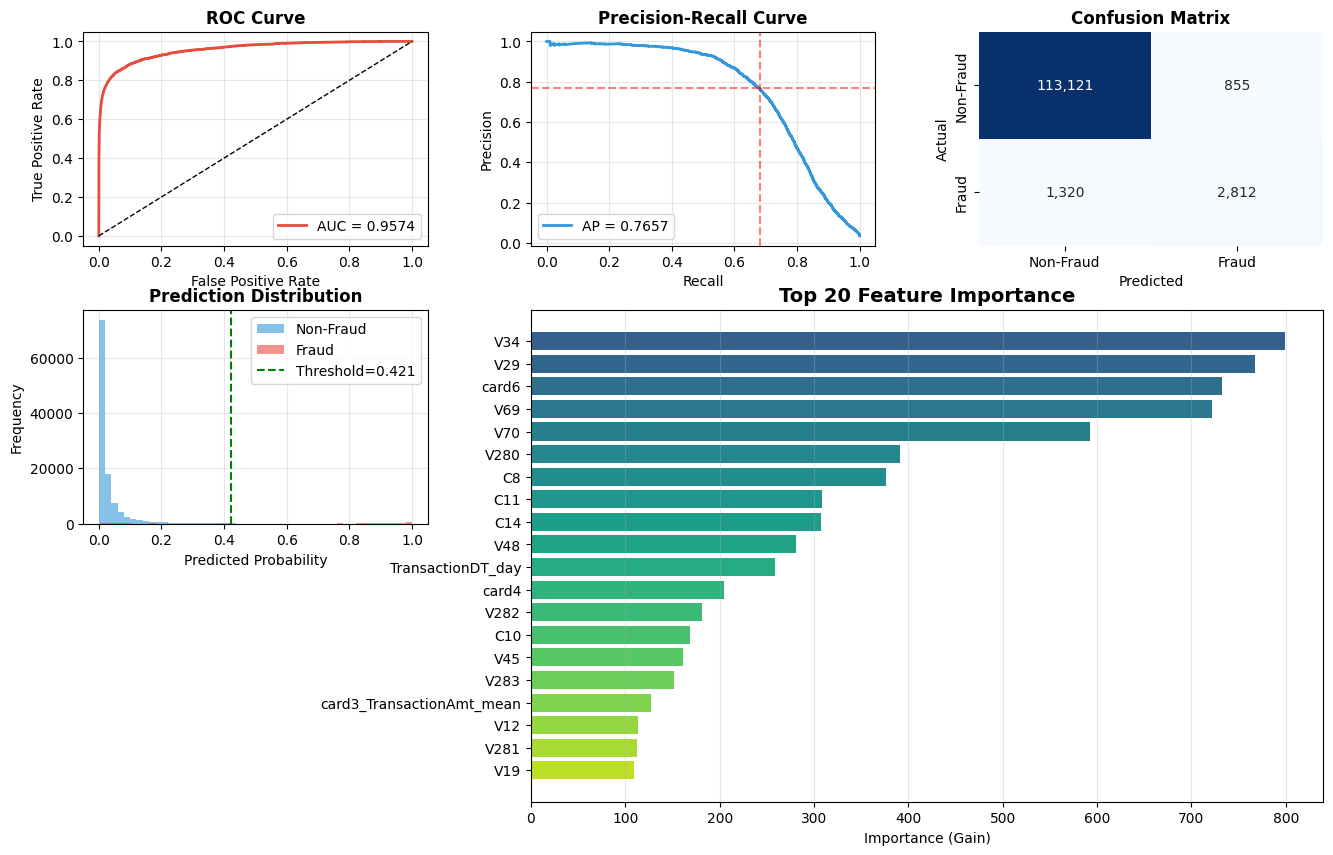


✅ Evaluation completed! Saved as 'model_evaluation.png'


9

In [21]:
print("\n📊 MODEL EVALUATION")
print("="*60)

# Predictions
dval_pred = xgb.DMatrix(X_val, feature_names=feature_names)
y_pred_proba = model.predict(dval_pred)

# ROC-AUC Score
roc_auc = roc_auc_score(y_val, y_pred_proba)
print(f"\n🎯 ROC-AUC Score: {roc_auc:.4f}")

# Average Precision Score
avg_precision = average_precision_score(y_val, y_pred_proba)
print(f"🎯 Average Precision Score: {avg_precision:.4f}")

# Find optimal threshold
precision, recall, thresholds = precision_recall_curve(y_val, y_pred_proba)
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-10)
optimal_idx = np.argmax(f1_scores)
optimal_threshold = thresholds[optimal_idx]

print(f"\n🎯 Optimal Threshold: {optimal_threshold:.4f}")
print(f"   Precision: {precision[optimal_idx]:.4f}")
print(f"   Recall: {recall[optimal_idx]:.4f}")
print(f"   F1-Score: {f1_scores[optimal_idx]:.4f}")

# Predictions with optimal threshold
y_pred = (y_pred_proba >= optimal_threshold).astype(int)

# Classification Report
from sklearn.metrics import classification_report, confusion_matrix
print(f"\n📋 Classification Report:")
print(classification_report(y_val, y_pred, target_names=['Non-Fraud', 'Fraud']))

# Confusion Matrix
cm = confusion_matrix(y_val, y_pred)
print(f"\n📋 Confusion Matrix:")
print(f"   TN: {cm[0,0]:,} | FP: {cm[0,1]:,}")
print(f"   FN: {cm[1,0]:,} | TP: {cm[1,1]:,}")

# Visualizations
fig = plt.figure(figsize=(16, 10))
gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

# 1. ROC Curve
ax1 = fig.add_subplot(gs[0, 0])
from sklearn.metrics import roc_curve
fpr, tpr, _ = roc_curve(y_val, y_pred_proba)
ax1.plot(fpr, tpr, color='#e74c3c', lw=2, label=f'AUC = {roc_auc:.4f}')
ax1.plot([0, 1], [0, 1], 'k--', lw=1)
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.set_title('ROC Curve', weight='bold')
ax1.legend()
ax1.grid(alpha=0.3)

# 2. Precision-Recall Curve
ax2 = fig.add_subplot(gs[0, 1])
ax2.plot(recall, precision, color='#3498db', lw=2, label=f'AP = {avg_precision:.4f}')
ax2.axvline(recall[optimal_idx], color='red', linestyle='--', alpha=0.5)
ax2.axhline(precision[optimal_idx], color='red', linestyle='--', alpha=0.5)
ax2.set_xlabel('Recall')
ax2.set_ylabel('Precision')
ax2.set_title('Precision-Recall Curve', weight='bold')
ax2.legend()
ax2.grid(alpha=0.3)

# 3. Confusion Matrix Heatmap
ax3 = fig.add_subplot(gs[0, 2])
sns.heatmap(cm, annot=True, fmt=',', cmap='Blues', ax=ax3, cbar=False)
ax3.set_xlabel('Predicted')
ax3.set_ylabel('Actual')
ax3.set_title('Confusion Matrix', weight='bold')
ax3.set_xticklabels(['Non-Fraud', 'Fraud'])
ax3.set_yticklabels(['Non-Fraud', 'Fraud'])

# 4. Prediction Distribution
ax4 = fig.add_subplot(gs[1, 0])
ax4.hist(y_pred_proba[y_val==0], bins=50, alpha=0.6, label='Non-Fraud', color='#3498db')
ax4.hist(y_pred_proba[y_val==1], bins=50, alpha=0.6, label='Fraud', color='#e74c3c')
ax4.axvline(optimal_threshold, color='green', linestyle='--', label=f'Threshold={optimal_threshold:.3f}')
ax4.set_xlabel('Predicted Probability')
ax4.set_ylabel('Frequency')
ax4.set_title('Prediction Distribution', weight='bold')
ax4.legend()
ax4.grid(alpha=0.3)

# 5. Feature Importance (Top 20)
ax5 = fig.add_subplot(gs[1:, 1:])
importance_dict = model.get_score(importance_type='gain')
importance_df = pd.DataFrame({
    'feature': importance_dict.keys(),
    'importance': importance_dict.values()
}).sort_values('importance', ascending=False).head(20)

colors = plt.cm.viridis(np.linspace(0.3, 0.9, len(importance_df)))
ax5.barh(range(len(importance_df)), importance_df['importance'].values, color=colors)
ax5.set_yticks(range(len(importance_df)))
ax5.set_yticklabels(importance_df['feature'].values)
ax5.set_xlabel('Importance (Gain)')
ax5.set_title('Top 20 Feature Importance', weight='bold', fontsize=14)
ax5.invert_yaxis()
ax5.grid(axis='x', alpha=0.3)

plt.savefig('model_evaluation.png', dpi=100, bbox_inches='tight')
plt.show()

print(f"\n✅ Evaluation completed! Saved as 'model_evaluation.png'")

# Free memory
del dval_pred
gc.collect()

# STEP 10: Generate Submission

Langkah terakhir berfokus pada penerapan model di dunia nyata. Pertama, dilakukan Submission, yaitu menghasilkan prediksi probabilitas untuk data tes. Selanjutnya, dilakukan Risk Categorization, di mana probabilitas prediksi (0–1) diubah menjadi kategori yang mudah dipahami manusia, seperti CRITICAL, HIGH, MEDIUM, dan LOW. Kategori ini membantu tim operasional atau analis penipuan dalam memprioritaskan kasus yang harus diperiksa secara manual. Selain itu, dibuat High Risk Report dengan mengekspor daftar transaksi berisiko tinggi (di atas Optimal Threshold) ke file high_risk_transactions.csv, sehingga tindakan segera seperti pemblokiran atau verifikasi manual dapat dilakukan dengan cepat.

In [22]:
print("\n📝 GENERATING PREDICTIONS")
print("="*60)

# Predict on test
dtest = xgb.DMatrix(X_test, feature_names=feature_names)
test_pred = model.predict(dtest)

# Create submission with probabilities
submission = pd.DataFrame({
    'TransactionID': test_ids,
    'isFraud': test_pred
})

submission.to_csv('submission.csv', index=False)

print(f"\n✅ Submission saved!")
print(f"   Shape: {submission.shape}")
print(f"   Mean fraud probability: {test_pred.mean():.4f}")
print(f"   Predictions > {optimal_threshold:.3f}: {(test_pred >= optimal_threshold).sum():,}")

print("\n" + submission.head(10).to_string(index=False))


📝 GENERATING PREDICTIONS

✅ Submission saved!
   Shape: (506691, 2)
   Mean fraud probability: 0.0766
   Predictions > 0.421: 18,926

 TransactionID  isFraud
       3663549 0.002460
       3663550 0.025075
       3663551 0.002872
       3663552 0.001982
       3663553 0.019998
       3663554 0.033923
       3663555 0.018223
       3663556 0.162361
       3663557 0.000289
       3663558 0.032146


# STEP 11: Fraud Analysis


🚨 FRAUD RISK ANALYSIS

📊 RISK CATEGORY SUMMARY:
   CRITICAL:  6,524 ( 1.29%)
   HIGH    :  3,264 ( 0.64%)
   MEDIUM  :  5,479 ( 1.08%)
   LOW     : 13,538 ( 2.67%)
   MINIMAL : 477,886 (94.32%)

🚨 TRANSACTIONS REQUIRING REVIEW (>= 0.421):
   Total: 18,926 transactions

📋 TOP 30 HIGH-RISK TRANSACTIONS:
 TransactionID  fraud_probability risk_category
       3897155           0.999846      CRITICAL
       3761175           0.999824      CRITICAL
       3739662           0.999807      CRITICAL
       3969781           0.999794      CRITICAL
       3969792           0.999749      CRITICAL
       3969788           0.999749      CRITICAL
       3729246           0.999735      CRITICAL
       3848080           0.999704      CRITICAL
       3862670           0.999701      CRITICAL
       3970460           0.999701      CRITICAL
       3969842           0.999699      CRITICAL
       3939312           0.999690      CRITICAL
       3843013           0.999688      CRITICAL
       3730453          

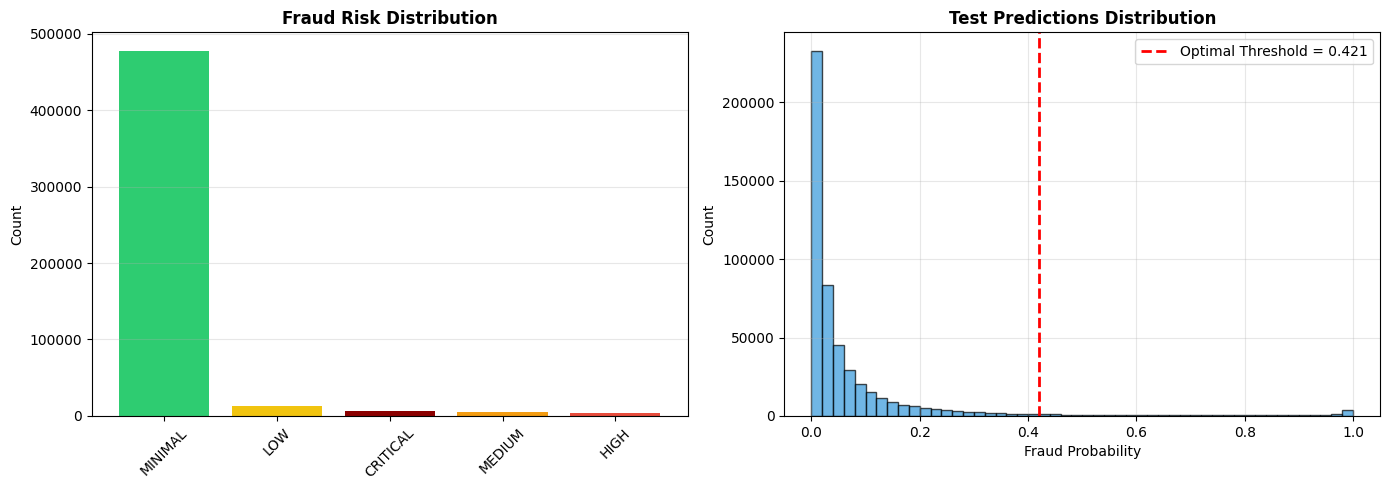


🎉 FRAUD DETECTION PIPELINE COMPLETED!

📈 Final Metrics:
   Validation ROC-AUC: 0.9574
   Average Precision: 0.7657
   Optimal Threshold: 0.4208

📁 Output Files:
   • submission.csv
   • fraud_risk_analysis.csv
   • high_risk_transactions.csv
   • model_evaluation.png
   • fraud_risk_analysis.png
   • eda_analysis.png


In [23]:
print("\n🚨 FRAUD RISK ANALYSIS")
print("="*60)

# Risk categories
def categorize_risk(prob):
    if prob >= 0.9:
        return 'CRITICAL'
    elif prob >= 0.7:
        return 'HIGH'
    elif prob >= 0.5:
        return 'MEDIUM'
    elif prob >= 0.3:
        return 'LOW'
    else:
        return 'MINIMAL'

# Create fraud analysis table
fraud_analysis = pd.DataFrame({
    'TransactionID': test_ids,
    'fraud_probability': test_pred,
    'risk_category': [categorize_risk(p) for p in test_pred]
})

# Sort by probability
fraud_analysis = fraud_analysis.sort_values('fraud_probability', ascending=False)

# Summary by risk category
print("\n📊 RISK CATEGORY SUMMARY:")
print("="*60)
risk_summary = fraud_analysis['risk_category'].value_counts()
for category in ['CRITICAL', 'HIGH', 'MEDIUM', 'LOW', 'MINIMAL']:
    count = risk_summary.get(category, 0)
    pct = (count / len(fraud_analysis)) * 100
    print(f"   {category:8s}: {count:6,} ({pct:5.2f}%)")

# High risk transactions
high_risk = fraud_analysis[fraud_analysis['fraud_probability'] >= optimal_threshold]
print(f"\n🚨 TRANSACTIONS REQUIRING REVIEW (>= {optimal_threshold:.3f}):")
print(f"   Total: {len(high_risk):,} transactions")

print(f"\n📋 TOP 30 HIGH-RISK TRANSACTIONS:")
print("="*60)
print(high_risk.head(30).to_string(index=False))

# Save fraud analysis
fraud_analysis.to_csv('fraud_risk_analysis.csv', index=False)
high_risk.to_csv('high_risk_transactions.csv', index=False)

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Risk category distribution
risk_colors = {'CRITICAL': '#8B0000', 'HIGH': '#e74c3c', 'MEDIUM': '#f39c12',
               'LOW': '#f1c40f', 'MINIMAL': '#2ecc71'}
risk_counts = fraud_analysis['risk_category'].value_counts()
colors = [risk_colors[cat] for cat in risk_counts.index]
axes[0].bar(range(len(risk_counts)), risk_counts.values, color=colors)
axes[0].set_xticks(range(len(risk_counts)))
axes[0].set_xticklabels(risk_counts.index, rotation=45)
axes[0].set_ylabel('Count')
axes[0].set_title('Fraud Risk Distribution', weight='bold')
axes[0].grid(axis='y', alpha=0.3)

# Probability distribution
axes[1].hist(test_pred, bins=50, color='#3498db', alpha=0.7, edgecolor='black')
axes[1].axvline(optimal_threshold, color='red', linestyle='--',
                label=f'Optimal Threshold = {optimal_threshold:.3f}', lw=2)
axes[1].set_xlabel('Fraud Probability')
axes[1].set_ylabel('Count')
axes[1].set_title('Test Predictions Distribution', weight='bold')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('fraud_risk_analysis.png', dpi=100, bbox_inches='tight')
plt.show()

print("\n" + "="*60)
print("🎉 FRAUD DETECTION PIPELINE COMPLETED!")
print("="*60)
print(f"\n📈 Final Metrics:")
print(f"   Validation ROC-AUC: {roc_auc:.4f}")
print(f"   Average Precision: {avg_precision:.4f}")
print(f"   Optimal Threshold: {optimal_threshold:.4f}")
print(f"\n📁 Output Files:")
print(f"   • submission.csv")
print(f"   • fraud_risk_analysis.csv")
print(f"   • high_risk_transactions.csv")
print(f"   • model_evaluation.png")
print(f"   • fraud_risk_analysis.png")
print(f"   • eda_analysis.png")
print("="*60)